In [87]:
!pip install livelossplot

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings
import pickle
import tensorflow as tf
import cv2
import random


from PIL import Image, ImageEnhance, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv("annotations.csv")

In [7]:
data.head()

,image,class
0,images/p7FhNESI-2TX5-aXiT-9nNv-f7LJlzc9BgqO.jpg,artificial_roughness
1,images/XJV2G0zl-scMm-HsbL-ovdy-J4mvzVQBO5uF.jpg,artificial_roughness
2,images/Yp1H0brV-VXZB-SZTa-PcFZ-Nes25RWxLgM4.jpg,artificial_roughness
3,images/VhuQ8Uqi-XxbK-TJwS-j5RN-ApJqVTBg0lbZ.jpg,artificial_roughness
4,images/LudjvYTM-V03e-BeaZ-6Sfj-bpeRzYmtG8Ew.jpg,artificial_roughness


In [55]:
images = []
labels = []

In [56]:
for i in tqdm(data.values):
  # images.append(cv2.imread("drive/MyDrive/" + i[0]))
  labels.append(i[1])

100%|██████████| 2014/2014 [00:00<00:00, 1150078.73it/s]


In [57]:
# with open("data.bf", "wb") as file:
#   pickle.dump(images, file)
with open("data.bf", "rb") as file:
  images = pickle.load(file)

In [58]:
images = np.array(images)
images.shape

(2014,)

In [59]:
def show_results(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history['val_accuracy']
    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(1, len(acc) + 1), acc, label='Training Accuracy')
    plt.plot(np.arange(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')
    plt.show()

In [60]:
encoder = LabelEncoder()

In [61]:
labels = encoder.fit_transform(labels)

In [62]:
for i in tqdm(range(len(images))):
  images[i] = cv2.resize(images[i], (50, 50))

100%|██████████| 2014/2014 [00:00<00:00, 70014.57it/s]


In [63]:
class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

In [64]:
class SVHNPolicy(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](Image.fromarray(img))

In [65]:
class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [66]:
images = np.array(list(images))
images.shape

(2014, 50, 50, 3)

In [67]:
from tensorflow.python.ops.logging_ops import ImageSummary
policy = SVHNPolicy()
img_data_train = images.copy()
imgs = img_data_train
lbl_data_train = labels.copy()
lbls = lbl_data_train
for i in range(10):
    img_data_train = np.concatenate((img_data_train, np.array(list(map(lambda x: np.asarray(policy(x)), imgs))).astype('uint8')))
    lbl_data_train = np.concatenate((lbl_data_train, lbls))
    print(len(lbl_data_train), img_data_train.shape)

4028 (4028, 50, 50, 3)
6042 (6042, 50, 50, 3)
8056 (8056, 50, 50, 3)
10070 (10070, 50, 50, 3)
12084 (12084, 50, 50, 3)
14098 (14098, 50, 50, 3)
16112 (16112, 50, 50, 3)
18126 (18126, 50, 50, 3)
20140 (20140, 50, 50, 3)
22154 (22154, 50, 50, 3)


In [68]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train, lbl_data_train, test_size=0.15, random_state=22)


In [69]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [70]:
train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

In [71]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(50, 50, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(8,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 50, 32)   9248        ['batch_normalization[0][0]']

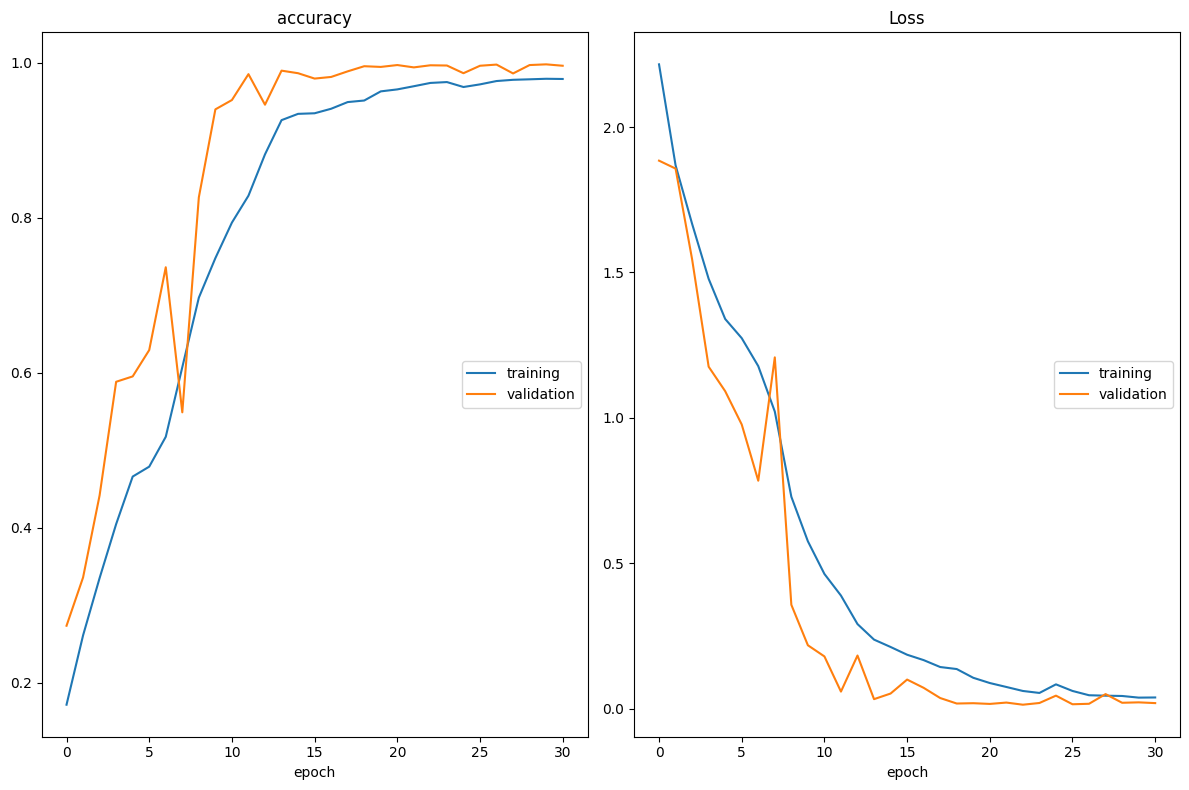

accuracy
	training         	 (min:    0.172, max:    0.979, cur:    0.979)
	validation       	 (min:    0.274, max:    0.998, cur:    0.996)
Loss
	training         	 (min:    0.038, max:    2.216, cur:    0.039)
	validation       	 (min:    0.014, max:    1.885, cur:    0.019)


In [73]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[early_stopping, PlotLossesKeras()], verbose=False)


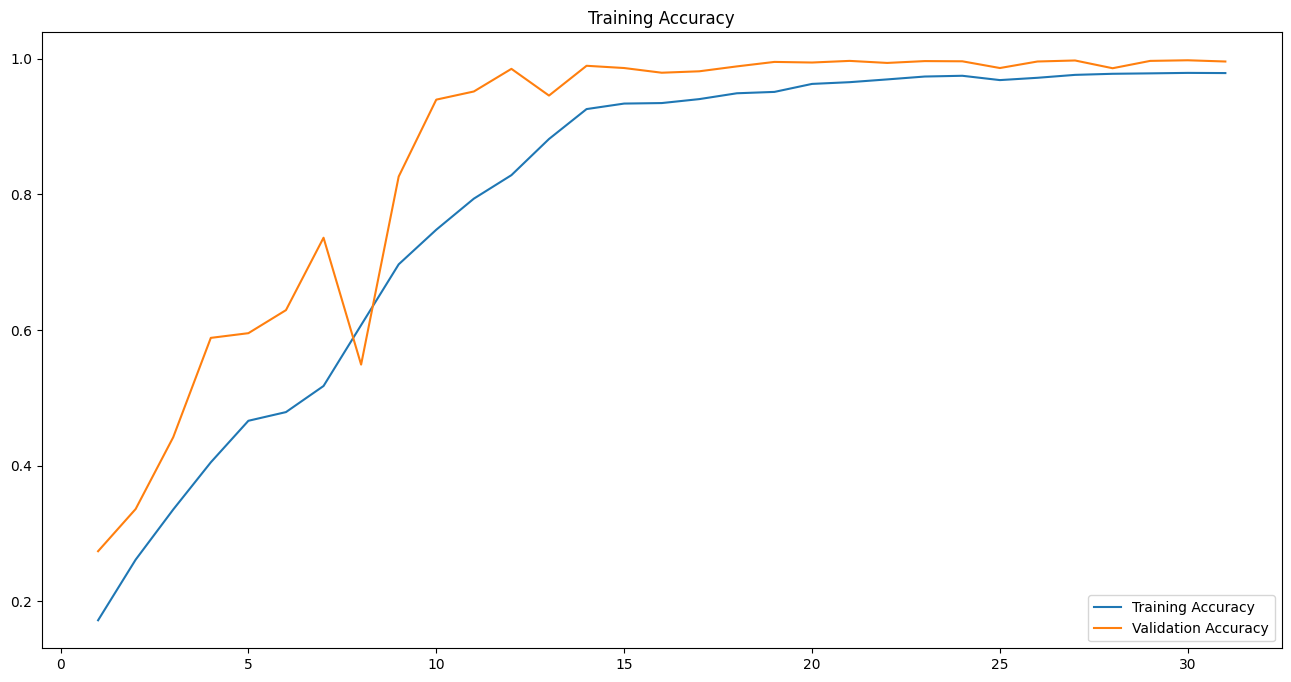

In [74]:
show_results(model_history)

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(classification_report(labels, np.argmax(model.predict(images), -1)))

63/63 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       243
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       260
           5       1.00      1.00      1.00       284
           6       1.00      1.00      1.00       312
           7       1.00      1.00      1.00       247

    accuracy                           1.00      2014
   macro avg       1.00      1.00      1.00      2014
weighted avg       1.00      1.00      1.00      2014



In [77]:
np.argmax(model.predict(images), -1)

63/63 [==============================] - 0s 2ms/step


array([0, 0, 0, ..., 7, 7, 7])

In [78]:
with open("encoder.bf", "wb") as file:
  pickle.dump(encoder, file)

In [80]:
model.save("drive/MyDrive/model")

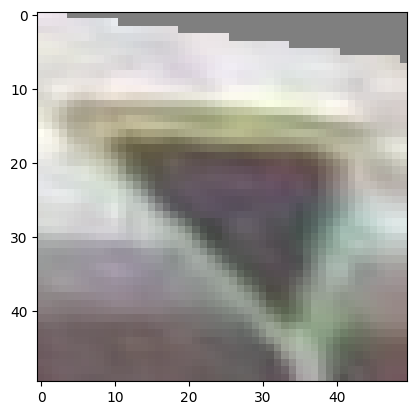

In [83]:
plt.imshow(train_images[2000])